In [1]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 8.7 MB/s eta 0:00:00


In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, average_precision_score, precision_recall_curve
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False
        self.best_model_weights = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_weights = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def restore_best_weights(self, model):
        model.load_state_dict(self.best_model_weights)

In [46]:
def load_data(filepath='creditcard.csv'):
    df = pd.read_csv(filepath)

    scaler = MinMaxScaler()
    cols_to_scale = df.columns.drop('Class')
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
    train_size = int(len(df) * 0.8)
    train_df = df.iloc[:train_size]
    test_df = df.iloc[train_size:]

    X_full = torch.FloatTensor(train_df.drop('Class', axis=1).values)
    y_full = torch.FloatTensor(train_df['Class'].values).unsqueeze(1)

    split_idx = int(len(X_full) * 0.9)
    X_train_mlp = X_full[:split_idx]
    y_train_mlp = y_full[:split_idx]
    X_val_mlp = X_full[split_idx:]
    y_val_mlp = y_full[split_idx:]

    X_test = torch.FloatTensor(test_df.drop('Class', axis=1).values)
    y_test = torch.FloatTensor(test_df['Class'].values).unsqueeze(1)

    train_normal = train_df[train_df['Class'] == 0]
    X_normal_full = torch.FloatTensor(train_normal.drop('Class', axis=1).values)

    split_ae = int(len(X_normal_full) * 0.9)
    X_train_ae = X_normal_full[:split_ae]
    X_val_ae = X_normal_full[split_ae:]

    return X_train_mlp, y_train_mlp, X_val_mlp, y_val_mlp, X_train_ae, X_val_ae, X_test, y_test

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim, layers_config, dropout_rate):
        super(MLP, self).__init__()
        layers = []
        in_dim = input_dim

        for h_dim in layers_config:
          layers.append(nn.Linear(in_dim, h_dim))
          layers.append(nn.BatchNorm1d(h_dim))
          layers.append(nn.LeakyReLU(0.2))
          layers.append(nn.Dropout(dropout_rate))
          in_dim = h_dim

        layers.append(nn.Linear(in_dim, 1))
        self.network = nn.Sequential(*layers)


    def forward(self, x):
        return self.network(x)


In [59]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 24),
            nn.BatchNorm1d(24),
            nn.Tanh(),

            nn.Linear(24, 16),
            nn.BatchNorm1d(16),
            nn.Tanh(),

            nn.Linear(16, 3),
            nn.LeakyReLU(0.2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 16),
            nn.BatchNorm1d(16),
            nn.Tanh(),

            nn.Linear(16, 24),
            nn.BatchNorm1d(24),
            nn.Tanh(),

            nn.Linear(24, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed


In [67]:
class TunedAutoencoder(nn.Module):
    def __init__(self, l1, l2, bottleneck):
        super(TunedAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(30, l1), nn.BatchNorm1d(l1), nn.Tanh(),
            nn.Linear(l1, l2), nn.BatchNorm1d(l2), nn.Tanh(),
            nn.Linear(l2, bottleneck), nn.LeakyReLU(0.2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck, l2), nn.BatchNorm1d(l2), nn.Tanh(),
            nn.Linear(l2, l1), nn.BatchNorm1d(l1), nn.Tanh(),
            nn.Linear(l1, 30), nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


In [79]:
def objective_mlp(trial, X_train, y_train, X_val, y_val):
    n_layers = trial.suggest_int("n_layers", 2, 4)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f"units_l{i}", 32, 256))

    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    model = MLP(30, layers, dropout).to(DEVICE)

    pos_weight_val = trial.suggest_float("pos_weight", 1.0, 20.0)
    pos_weight = torch.tensor([pos_weight_val]).to(DEVICE)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    dataset = TensorDataset(X_train, y_train)
    loader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True)

    for epoch in range(3):
        model.train()
        for bx, by in loader:
            bx, by = bx.to(DEVICE), by.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(bx), by)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():

            val_logits = model(X_val.to(DEVICE))
            val_probs = torch.sigmoid(val_logits).cpu().numpy()

            score = average_precision_score(y_val.cpu().numpy(), val_probs)

        trial.report(score, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return score

In [92]:
import torch.nn.functional as F

def objective_ae_advanced(trial, X_train, X_val, y_val):
    bottleneck = trial.suggest_int("bottleneck", 2, 6)
    l1_size = trial.suggest_int("l1", 16, 28)
    l2_size = trial.suggest_int("l2", 8, 14)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)


    loss_name = trial.suggest_categorical("loss", ["MSE", "L1", "BCE"])

    class TrialAE(nn.Module):
        def __init__(self):
            super().__init__()
            self.encoder = nn.Sequential(
                nn.Linear(30, l1_size), nn.BatchNorm1d(l1_size), nn.Tanh(),
                nn.Linear(l1_size, l2_size), nn.BatchNorm1d(l2_size), nn.Tanh(),
                nn.Linear(l2_size, bottleneck), nn.LeakyReLU(0.2)
            )
            self.decoder = nn.Sequential(
                nn.Linear(bottleneck, l2_size), nn.BatchNorm1d(l2_size), nn.Tanh(),
                nn.Linear(l2_size, l1_size), nn.BatchNorm1d(l1_size), nn.Tanh(),
                nn.Linear(l1_size, 30), nn.Sigmoid()
            )
        def forward(self, x):
            return self.decoder(self.encoder(x))

    model = TrialAE().to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    if loss_name == "MSE":
        criterion = nn.MSELoss()
    elif loss_name == "L1":
        criterion = nn.L1Loss()
    else:
        criterion = nn.BCELoss()

    loader = DataLoader(TensorDataset(X_train), batch_size=256, shuffle=True)

    for epoch in range(5):
        model.train()
        for bx in loader:
            bx = bx[0].to(DEVICE)
            optimizer.zero_grad()
            recon = model(bx)
            loss = criterion(recon, bx)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_in = X_val.to(DEVICE)
            val_out = model(val_in)

            if loss_name == "BCE":
                errors = F.binary_cross_entropy(val_out, val_in, reduction='none').mean(dim=1)
            else:
                errors = torch.mean(torch.abs(val_out - val_in), dim=1)

            score = average_precision_score(y_val.cpu().numpy(), errors.cpu().numpy())

        trial.report(score, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return score


In [81]:
def train_final_mlp(params, X_train, y_train, X_test,X_val, y_val,epochs=10):
    print("\nTraining Advanced MLP...")
    layers = [params[f"units_l{i}"] for i in range(params["n_layers"])]
    model = MLP(30, layers, params["dropout"]).to(DEVICE)

    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    pos_weight = (n_neg / n_pos).to(DEVICE)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    early_stopper = EarlyStopping(patience=6, min_delta=0.001)
    loader = DataLoader(TensorDataset(X_train, y_train), batch_size=256, shuffle=True, drop_last=True)

    losses = []
    for epoch in range(50):
        model.train()
        epoch_loss = 0
        for bx, by in loader:
            bx, by = bx.to(DEVICE), by.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(bx), by)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_loss = epoch_loss / len(loader)
        losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            val_out = model(X_val.to(DEVICE))
            val_loss = criterion(val_out, y_val.to(DEVICE)).item()

        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f}")

        scheduler.step(val_loss)
        early_stopper(val_loss, model)

        if early_stopper.early_stop:
            print(f"Early Stopping MLP at epoch {epoch+1}")
            break

    early_stopper.restore_best_weights(model)
    model.eval()
    with torch.no_grad():
        probs = torch.sigmoid(model(X_test.to(DEVICE))).cpu().numpy()
        preds = (probs > 0.5).astype(int)

    return preds, losses, probs

In [93]:
def train_deep_ae(X_train, X_val, X_test,epochs=10):
    print("\nTraining Deep Autoencoder...")
    model = Autoencoder(30).to(DEVICE)
    criterion = nn.L1Loss()
    optimizer = optim.AdamW(model.parameters(), lr=0.002)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    early_stopper = EarlyStopping(patience=8, min_delta=1e-5)
    loader = DataLoader(TensorDataset(X_train), batch_size=256, shuffle=True, drop_last=True)

    train_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for bx in loader:
            bx = bx[0].to(DEVICE)
            optimizer.zero_grad()
            recon = model(bx)
            loss = criterion(recon, bx)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        train_losses.append(avg_loss)

        model.eval()
        with torch.no_grad():
            val_recon = model(X_val.to(DEVICE))
            val_loss = criterion(val_recon, X_val.to(DEVICE)).item()

        scheduler.step(val_loss)
        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            print(f"Early Stopping at epoch {epoch+1}")
            break
        if epoch % 5 == 0: print(f"Epoch {epoch}: Train Loss {avg_loss:.5f}, Val Loss {val_loss:.5f}")
    early_stopper.restore_best_weights(model)
    model.eval()
    with torch.no_grad():
        val_recon = model(X_val.to(DEVICE))
        val_errors = torch.mean((val_recon - X_val.to(DEVICE))**2, dim=1).cpu().numpy()

        threshold = np.mean(val_errors) + 3 * np.std(val_errors)
        print(f"Deep AE Threshold: {threshold:.5f}")

    with torch.no_grad():
        test_recon = model(X_test.to(DEVICE))
        test_errors = torch.mean((test_recon - X_test.to(DEVICE))**2, dim=1).cpu().numpy()

    preds = (test_errors > threshold).astype(int)
    return preds, train_losses, threshold, test_errors


In [99]:
def train_tuned_ae(best_params, X_train, X_val, X_test, epochs=50):
    l1 = best_params['l1']
    l2 = best_params['l2']
    bottleneck = best_params['bottleneck']
    lr = best_params['lr']
    loss_type = best_params['loss']

    print(f"\nTraining Tuned AE (Loss: {loss_type}, L1:{l1}, L2:{l2}, BN:{bottleneck})...")

    model = TunedAutoencoder(l1, l2, bottleneck).to(DEVICE)

    if loss_type == "MSE":
        criterion = nn.MSELoss()
    elif loss_type == "L1":
        criterion = nn.L1Loss()
    else:
        criterion = nn.BCELoss()

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    early_stopper = EarlyStopping(patience=10, min_delta=1e-5)

    loader = DataLoader(TensorDataset(X_train), batch_size=256, shuffle=True, drop_last=True)
    train_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for bx in loader:
            bx = bx[0].to(DEVICE)
            optimizer.zero_grad()
            recon = model(bx)
            loss = criterion(recon, bx)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        train_losses.append(avg_loss)

        model.eval()
        with torch.no_grad():
            val_in = X_val.to(DEVICE)
            val_out = model(val_in)
            val_loss = criterion(val_out, val_in).item()

        scheduler.step(val_loss)
        early_stopper(val_loss, model)

        if early_stopper.early_stop:
            print(f"Early Stopping at epoch {epoch+1}")
            break
        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Train Loss {avg_loss:.5f}, Val Loss {val_loss:.5f}")

    early_stopper.restore_best_weights(model)

    model.eval()
    with torch.no_grad():
        val_in = X_val.to(DEVICE)
        val_out = model(val_in)

        if loss_type == "BCE":
            val_errors = F.binary_cross_entropy(val_out, val_in, reduction='none').mean(dim=1).cpu().numpy()
        else:
            val_errors = torch.mean(torch.abs(val_out - val_in), dim=1).cpu().numpy()

        threshold = np.mean(val_errors) + 3 * np.std(val_errors)
        print(f"Deep AE Threshold: {threshold:.5f}")

        test_in = X_test.to(DEVICE)
        test_out = model(test_in)

        if loss_type == "BCE":
            test_errors = F.binary_cross_entropy(test_out, test_in, reduction='none').mean(dim=1).cpu().numpy()
        else:
            test_errors = torch.mean(torch.abs(test_out - test_in), dim=1).cpu().numpy()

    preds = (test_errors > threshold).astype(int)
    return preds, train_losses, threshold, test_errors

In [95]:
X_train_mlp, y_train_mlp, X_val_mlp, y_val_mlp, X_train_ae, X_val_ae, X_test, y_test = load_data()
y_test_np = y_test.numpy()

Loading and preprocessing data...


In [84]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda t: objective_mlp(t, X_train_mlp, y_train_mlp, X_val_mlp, y_val_mlp), n_trials=20)

[I 2026-02-01 17:35:02,763] A new study created in memory with name: no-name-7cd0a0af-9b6f-4389-9890-d16e040d173a
[I 2026-02-01 17:35:14,738] Trial 0 finished with value: 0.8211853602953473 and parameters: {'n_layers': 4, 'units_l0': 251, 'units_l1': 169, 'units_l2': 202, 'units_l3': 50, 'dropout': 0.13860005108812012, 'lr': 0.0009734091950488143, 'pos_weight': 15.664892071485964}. Best is trial 0 with value: 0.8211853602953473.
[I 2026-02-01 17:35:25,414] Trial 1 finished with value: 0.8191844761673863 and parameters: {'n_layers': 3, 'units_l0': 125, 'units_l1': 38, 'units_l2': 235, 'dropout': 0.41240424564559797, 'lr': 0.0004332730378844247, 'pos_weight': 2.4072165642225993}. Best is trial 0 with value: 0.8211853602953473.
[I 2026-02-01 17:35:36,158] Trial 2 finished with value: 0.802149856103844 and parameters: {'n_layers': 3, 'units_l0': 70, 'units_l1': 246, 'units_l2': 190, 'dropout': 0.25323877529935357, 'lr': 0.0034912231707248044, 'pos_weight': 1.6888463837669152}. Best is tria

In [85]:
mlp_preds, mlp_loss_curve,mlp_probs = train_final_mlp(study.best_params, X_train_mlp, y_train_mlp, X_test,X_val_mlp,y_val_mlp,epochs=50)


Training Advanced MLP...
Epoch 1: Train Loss 0.4654 | Val Loss 0.3743
Epoch 2: Train Loss 0.3301 | Val Loss 0.3039
Epoch 3: Train Loss 0.3016 | Val Loss 0.3242
Epoch 4: Train Loss 0.2759 | Val Loss 0.3085
Epoch 5: Train Loss 0.2520 | Val Loss 0.4484
Epoch 6: Train Loss 0.2196 | Val Loss 0.3770
Epoch 7: Train Loss 0.2117 | Val Loss 0.3570
Epoch 8: Train Loss 0.2126 | Val Loss 0.3485
Early Stopping MLP at epoch 8


In [97]:
study_ae = optuna.create_study(direction="maximize")
study_ae.optimize(lambda t: objective_ae_advanced(t, X_train_ae, X_val_mlp, y_val_mlp), n_trials=20)

print("Best AE params:", study_ae.best_params)

[I 2026-02-01 17:47:52,567] A new study created in memory with name: no-name-8525c888-55c4-4db4-8a05-0c9c5ae18ed6
[I 2026-02-01 17:48:09,743] Trial 0 finished with value: 0.121155692516931 and parameters: {'bottleneck': 4, 'l1': 24, 'l2': 8, 'lr': 0.00196570220833481, 'loss': 'MSE'}. Best is trial 0 with value: 0.121155692516931.
[I 2026-02-01 17:48:26,683] Trial 1 finished with value: 0.10375591840933267 and parameters: {'bottleneck': 6, 'l1': 26, 'l2': 10, 'lr': 0.0001998358899011316, 'loss': 'L1'}. Best is trial 0 with value: 0.121155692516931.
[I 2026-02-01 17:48:43,435] Trial 2 finished with value: 0.11581208923753009 and parameters: {'bottleneck': 6, 'l1': 17, 'l2': 14, 'lr': 0.0013851019411004048, 'loss': 'L1'}. Best is trial 0 with value: 0.121155692516931.
[I 2026-02-01 17:49:01,584] Trial 3 finished with value: 0.12070358163628112 and parameters: {'bottleneck': 2, 'l1': 17, 'l2': 10, 'lr': 0.0006921261123746813, 'loss': 'L1'}. Best is trial 0 with value: 0.121155692516931.
[I

Best AE params: {'bottleneck': 5, 'l1': 22, 'l2': 11, 'lr': 0.0003714460274353854, 'loss': 'MSE'}


In [100]:
best_ae_params = study_ae.best_params
ae_preds, ae_loss_curve, ae_thresh, ae_scores = train_tuned_ae(
    best_ae_params,
    X_train_ae,
    X_val_ae,
    X_test
)


Training Tuned AE (Loss: MSE, L1:22, L2:11, BN:5)...
Epoch 0: Train Loss 0.01666, Val Loss 0.00290
Epoch 5: Train Loss 0.00114, Val Loss 0.00139
Epoch 10: Train Loss 0.00087, Val Loss 0.00110
Epoch 15: Train Loss 0.00079, Val Loss 0.00106
Epoch 20: Train Loss 0.00076, Val Loss 0.00101
Early Stopping at epoch 23
Deep AE Threshold: 0.04269


In [101]:
mlp_auprc = average_precision_score(y_test_np, mlp_probs)
ae_auprc = average_precision_score(y_test_np, ae_scores)

In [102]:
print(f"MLP AUPRC: {mlp_auprc:.4f}")
print(f"Autoencoder AUPRC: {ae_auprc:.4f}")

MLP AUPRC: 0.7449
Autoencoder AUPRC: 0.1689


In [103]:
m_prec, m_rec, _ = precision_recall_curve(y_test_np, mlp_probs)
a_prec, a_rec, _ = precision_recall_curve(y_test_np, ae_scores)

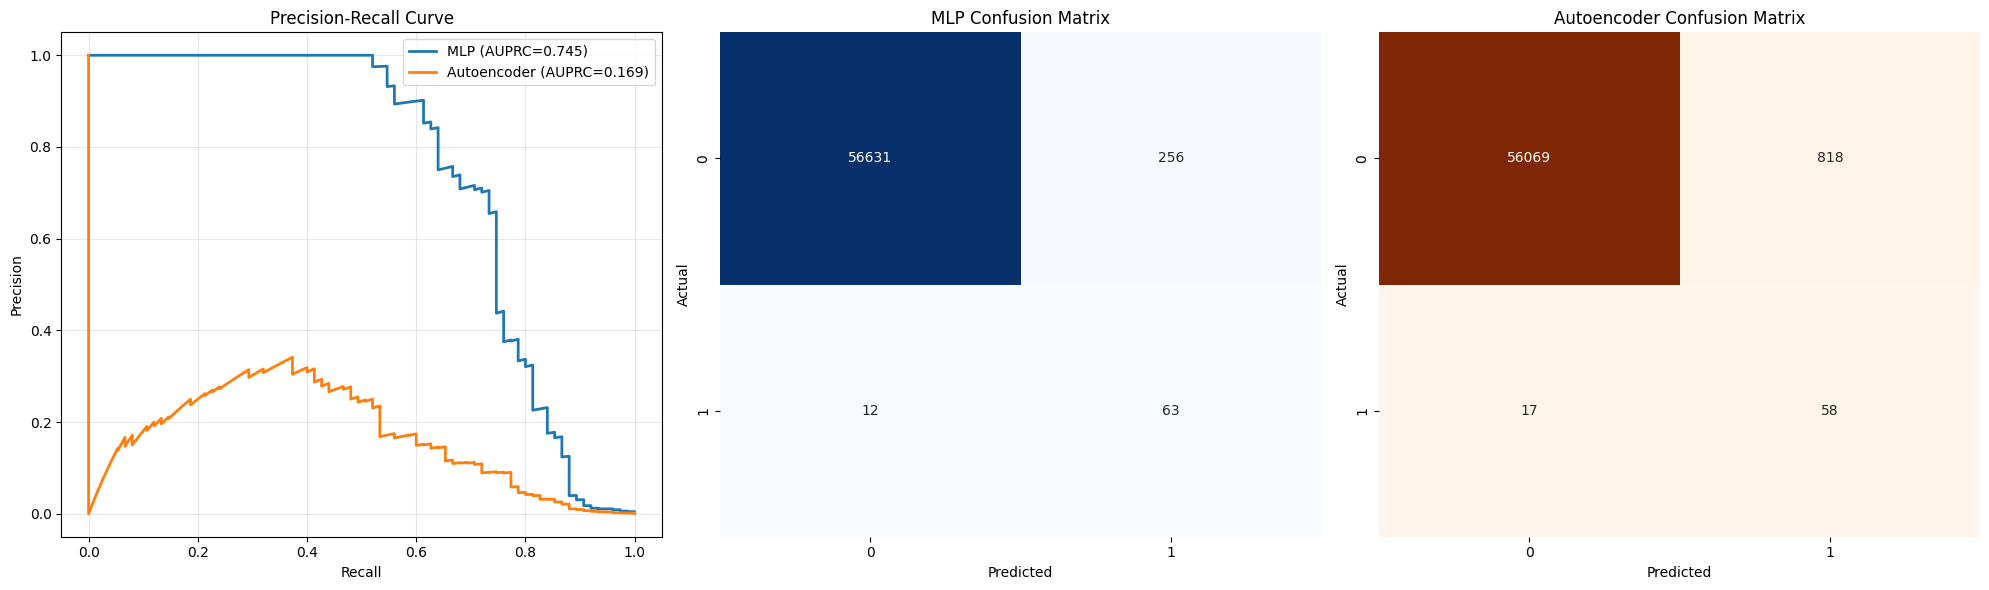

In [105]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(m_rec, m_prec, label=f'MLP (AUPRC={mlp_auprc:.3f})', linewidth=2)
ax1.plot(a_rec, a_prec, label=f'Autoencoder (AUPRC={ae_auprc:.3f})', linewidth=2)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve')
ax1.legend()
ax1.grid(True, alpha=0.3)

mlp_preds_final = (mlp_probs > 0.5).astype(int)
cm_mlp = confusion_matrix(y_test_np, mlp_preds_final)

sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', ax=ax2, cbar=False)
ax2.set_title('MLP Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
cm_ae = confusion_matrix(y_test_np, ae_preds)

sns.heatmap(cm_ae, annot=True, fmt='d', cmap='Oranges', ax=ax3, cbar=False)
ax3.set_title('Autoencoder Confusion Matrix')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [106]:
from sklearn.metrics import classification_report

print("MLP Classification Repor")
print(classification_report(y_test_np, mlp_preds, target_names=['Normal', 'Fraud'], digits=4))

print("Autoencoder Classification Report")
print(classification_report(y_test_np, ae_preds, target_names=['Normal', 'Fraud'], digits=4))


MLP Classification Repor
              precision    recall  f1-score   support

      Normal     0.9998    0.9955    0.9976     56887
       Fraud     0.1975    0.8400    0.3198        75

    accuracy                         0.9953     56962
   macro avg     0.5986    0.9177    0.6587     56962
weighted avg     0.9987    0.9953    0.9967     56962

Autoencoder Classification Report
              precision    recall  f1-score   support

      Normal     0.9997    0.9856    0.9926     56887
       Fraud     0.0662    0.7733    0.1220        75

    accuracy                         0.9853     56962
   macro avg     0.5330    0.8795    0.5573     56962
weighted avg     0.9985    0.9853    0.9915     56962

